In [1]:
import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_4/Simulation_Data/"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)        #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)             #DM component

In [3]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 4.100                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
r_s    = 11.5
ml     = 7.00                                                          #mass to light ratio
phi_shear = 88                                                         #Inclination of external shear [deg]
mag_shear = 0.02                                                       #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

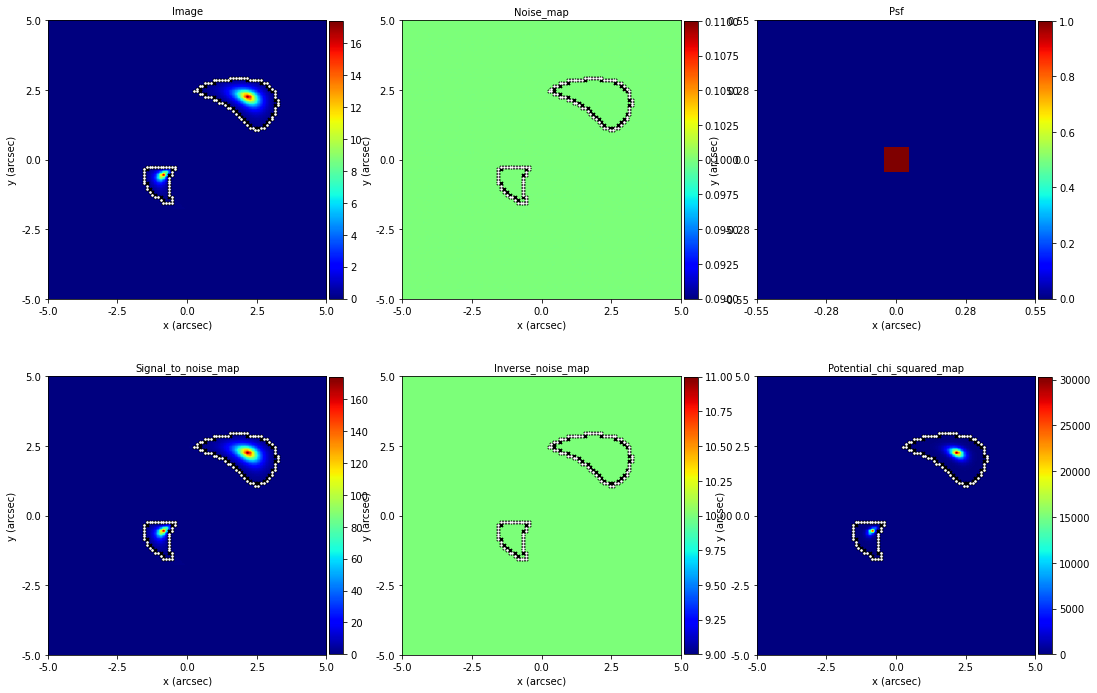

In [4]:
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/arcs_simulation.fits",
        noise_map_path=f"{data_folder}/noise_simulation.fits",
        psf_path=f"{data_folder}/psf_simulation.fits",
        pixel_scales=0.1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/new_mask.fits", hdu=1, 
                                    pixel_scales=imaging.pixel_scales)

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)     #Masked image


aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=True),                         #Plot
)

In [5]:
#MGE mass profile

#Initializing
mass_profile_MGE = al.mp.MGE()


#Components
mass_profile_MGE.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm =kappa_* surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

#Grid
#mass_profile.MGE_Grid_parameters(masked_image.grid)

#Lens galaxy
lens_galaxy_MGE = al.Galaxy(
    redshift=z_l,
    mass=mass_profile_MGE,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [6]:
#MGE mass profile

#Initializing
mass_profile_Both = al.mp.MGE()
ell_comp = al.convert.elliptical_comps_from(axis_ratio=qobs_dm[0], phi=0.0)
eNFW = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_,elliptical_comps=ell_comp,scale_radius=r_s)

#Components
mass_profile_Both.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh)
mass_profile_Both.Analytic_Model(eNFW)

#Grid
#mass_profile.MGE_Grid_parameters(masked_image.grid)

#Lens galaxy
lens_galaxy_Both = al.Galaxy(
    redshift=z_l,
    mass=mass_profile_Both,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [7]:
grid = al.Grid.uniform(shape_2d=(80, 80), pixel_scales=0.1, sub_size=1)

In [8]:
result_MGE  = lens_galaxy_MGE.deflections_from_grid(grid)
result_Both = lens_galaxy_Both.deflections_from_grid(grid)

Text(0.5, 1.0, '$\\alpha_y$')

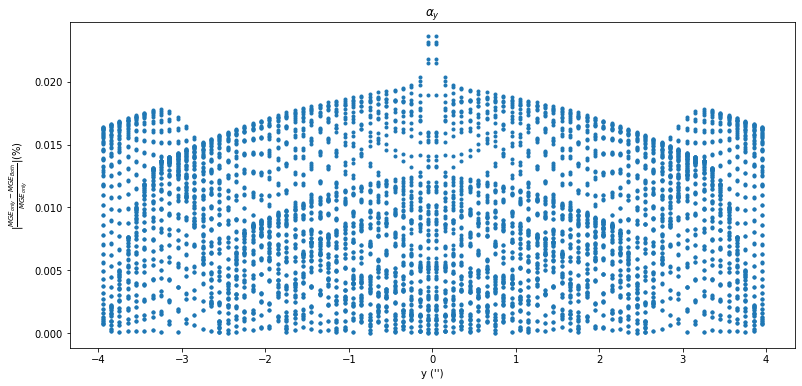

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,6))


plt.plot(grid[:,0], 100 * abs(result_MGE[:,0]-result_Both[:,0])/abs(result_MGE[:,0]), ".")
plt.ylabel("$|\\frac{MGE_{only} - MGE_{Both}}{MGE_{only}}|$(%)")
plt.xlabel("y ('')")
plt.title("$\\alpha_y$")

Text(0.5, 1.0, '$\\alpha_x$')

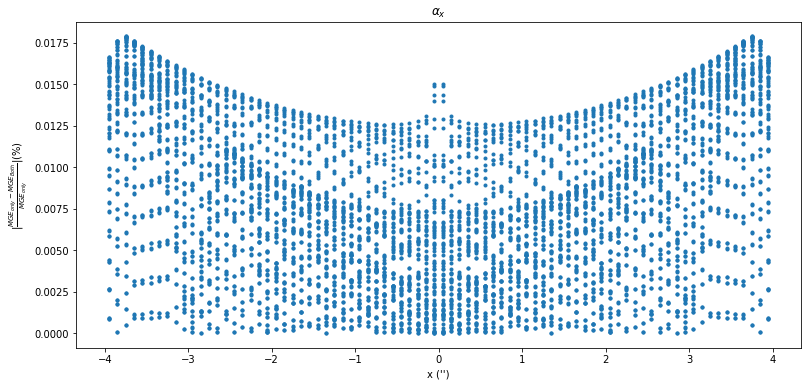

In [10]:
plt.figure(figsize=(13,6))

plt.plot(grid[:,1],100 * abs(result_MGE[:,1]-result_Both[:,1])/abs(result_MGE[:,1]), ".")
plt.ylabel("$|\\frac{MGE_{only} - MGE_{Both}}{MGE_{only}}|$(%)")
plt.xlabel("x ('')")
plt.title("$\\alpha_x$")